<h1><center> ComS 573     </center></h1>
<h1><center> Lab 2 </center></h1>
<h1><center> Kanak Choudhury </center></h1>

# Problem 1
## (b)

For this problem, I have used the following parameter combinations
    
    hidden_layers = [1,2,3]
    hidden_units = [50, 64, 80]
    num_epochs = [10, 50, 100]
    btch_size = [128, 200, 300]
    learning_rate = [0.1, 0.5, 0.9]
    momentum = [.3, .5, 0.9]
    loss_func = ['categorical_crossentropy']
    data_scaling = ['Standardize', 'Normalize']
    activation_func = ['relu', 'tanh']

Also used 80% - 20% training - validation data.

In [6]:
import numpy as np
import pandas as pd
import sklearn.preprocessing
import matplotlib
import keras
import re
import sys
import gc
import time

print('python ' +sys.version)
print('numpy '+ np.__version__)
print('pandas '+ pd.__version__)
print('sklearn '+ sklearn.__version__)
print('matplotlib '+ matplotlib.__version__)
print('keras '+ keras.__version__)
print('re '+ re.__version__)


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from itertools import product

python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.1
matplotlib 3.1.3
keras 2.3.1
re 2.2.1


In [7]:
path  = 'D:/ISU/COMS 573 - Machine Learning/HW/Lab2/'
train_model = False

df_tr = pd.read_csv(path+'optdigits.tra',header=None)
X_tr, y_tr = df_tr.loc[:,0:63], df_tr.loc[:,64]
ccat = y_tr.unique().size

df_ts = pd.read_csv(path+'optdigits.tes',header=None)
X_ts,  y_ts  = df_ts.loc[:,0:63],  df_ts.loc[:,64]

scaler = StandardScaler().fit(X_tr)
normalizer = Normalizer().fit(X_tr)

X_tr_std = scaler.transform(X_tr)
X_tr_norm = normalizer.transform(X_tr)


split = 0.8
size = np.shape(X_tr)
nsplit = int(np.floor(split*size[0]))

y_train1 = np_utils.to_categorical(y_tr, ccat)
y_train = y_train1[0:nsplit,:];
y_val = y_train1[nsplit:size[0],:];
y_test = np_utils.to_categorical(y_ts, ccat)


X_train_std = X_tr_std[0:nsplit,:];
X_val_std = X_tr_std[nsplit:size[0],:];
X_test_std = scaler.transform(X_ts)


X_train_norm = X_tr_norm[0:nsplit,:];
X_val_norm = X_tr_norm[nsplit:size[0],:];
X_test_norm = normalizer.transform(X_ts)

In [8]:
if train_model:
    hidden_layers = [1,2,3]
    hidden_units = [50, 64, 80]
    num_epochs = [10, 50, 100]
    btch_size = [128, 200, 300]
    learning_rate = [0.1, 0.5, 0.9]
    momentum = [.3, .5, 0.9]
    loss_func = ['categorical_crossentropy']
    data_scaling = ['Standardize', 'Normalize']
    activation_func = ['relu', 'tanh']


    def expand_grid(dictionary):
       return pd.DataFrame([row for row in product(*dictionary.values())], 
                           columns=dictionary.keys())

    dictionary = {'hidden_layers': hidden_layers,
                  'hidden_units': hidden_units,
                  'num_epochs': num_epochs, 
                  'batch_size': btch_size,
                  'learning_rate': learning_rate,
                  'momentum': momentum,
                  'loss_func': loss_func,
                  'data_scaling': data_scaling,
                  'activation_func': activation_func}

    prem1 = expand_grid(dictionary)
    prem1 = prem1[~((prem1['activation_func'] == 'tanh') & (prem1['loss_func'] == 'mean_squared_error'))]
    prem1['time'] = np.NaN
    prem1['train_loss'] = np.NaN
    prem1['validation_loss'] = np.NaN
    prem1['test_loss'] = np.NaN
    prem1['train_acc'] = np.NaN
    prem1['validation_acc'] = np.NaN
    prem1['test_acc'] = np.NaN
    size_prem1 = prem1.shape
    print(prem1.head())

    ll = 0 
    for j in range(0,2):
        if j == 0:
            X_train = X_train_std
            X_val = X_val_std
            X_test = X_test_std
            listind = prem1[prem1['data_scaling'] == 'Standardize'].index.tolist()
        else:
            X_train = X_train_norm
            X_val = X_val_norm
            X_test = X_test_norm
            listind = prem1[prem1['data_scaling'] == 'Normalize'].index.tolist()

        for i in listind:
            start = time. time()
            if prem1.iloc[i,0] == 1:
                model = Sequential()
                model.add(Dense(prem1.iloc[i,1], input_dim=64, activation=prem1.iloc[i,8]))
                model.add(Dense(ccat, activation='softmax'))

            elif prem1.iloc[i,0] == 2:
                model = Sequential()
                model.add(Dense(prem1.iloc[i,1], input_dim=64, activation=prem1.iloc[i,8]))
                model.add(Dense(prem1.iloc[i,1], activation=prem1.iloc[i,8]))
                model.add(Dense(ccat, activation='softmax'))

            elif prem1.iloc[i,0] == 3:
                model = Sequential()
                model.add(Dense(prem1.iloc[i,1], input_dim=64, activation=prem1.iloc[i,8]))
                model.add(Dense(prem1.iloc[i,1], activation=prem1.iloc[i,8]))
                model.add(Dense(prem1.iloc[i,1], activation=prem1.iloc[i,8]))
                model.add(Dense(ccat, activation='softmax'))

            else:
                model = Sequential()
                model.add(Dense(prem1.iloc[i,1], input_dim=64, activation=prem1.iloc[i,8]))
                model.add(Dense(prem1.iloc[i,1], activation=prem1.iloc[i,8]))
                model.add(Dense(prem1.iloc[i,1], activation=prem1.iloc[i,8]))
                model.add(Dense(prem1.iloc[i,1], activation=prem1.iloc[i,8]))
                model.add(Dense(ccat, activation='softmax'))


            es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=200)
            mc = ModelCheckpoint('best_model', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)


            optimizer1 = optimizers.SGD(lr=prem1.iloc[i,4], momentum=prem1.iloc[i,5])
            model.compile(optimizer=optimizer1, loss=prem1.iloc[i,6], metrics=['accuracy'])
            fit1 = model.fit(X_train,y_train, batch_size=prem1.iloc[i,3], epochs=prem1.iloc[i,2], 
                             validation_data=(X_val,y_val), callbacks=[es, mc], verbose = 0)
            fit = load_model('best_model')
            end = time.time()
            train_accuracy = fit.evaluate(X_train, y_train, verbose=0)
            val_accuracy = fit.evaluate(X_val, y_val, verbose=0)
            test_accuracy = fit.evaluate(X_test, y_test, verbose=0)
            prem1.iloc[i, 9:16] = [end-start, train_accuracy[0], val_accuracy[0], test_accuracy[0], 
                                  train_accuracy[1], val_accuracy[1], test_accuracy[1]]


            del model, es, mc, optimizer1, fit, fit1
            gc.collect()
            ll = ll+1
            sys.stdout.write("\r Progress: %.2f%%" %round(float(ll)/size_prem1[0]*100,2))
            sys.stdout.flush()
else:
    print('skiped model fit')

skiped model fit



 Best 10 hyper-parameter combination for tanh:
       hidden_layers  hiden_units  num_epochs  batch_size  learning_rate  \
1210              3           64          50         200            0.1   
892               2           80          50         200            0.5   
928               2           80         100         128            0.5   
1220              3           64          50         200            0.9   
800               2           64         100         300            0.5   
1090              3           50         100         128            0.5   
1270              3           64         100         200            0.5   
623               2           50         100         200            0.5   
946               2           80         100         200            0.5   
1106              3           50         100         200            0.5   

      momentum                 loss_func data_scaling activation_func  \
1210       0.9  categorical_crossentropy  Standardiz

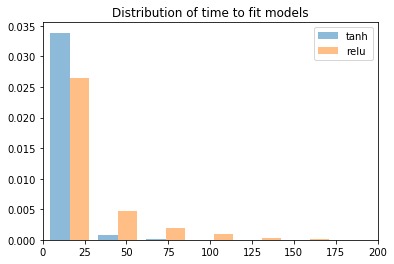

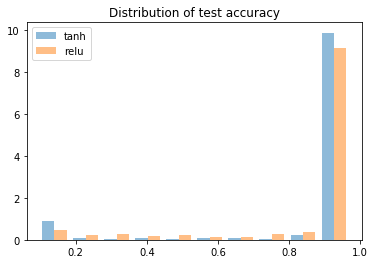

In [9]:
if train_model:
    prem1.to_csv (path+'res_1b.csv', index = False, header=True)
else:
    prem221 = pd.read_csv(path+'res_1b.csv',header=0)
    prem222 = pd.read_csv(path+'res_1a.csv',header=0)
    
    prem222 = prem222[((prem222['activation_func']=='relu') & (prem222['loss_func']=='categorical_crossentropy'))]
    prem1 = prem221.append(prem222)
    del prem221, prem222

    
top10_relu = prem1[prem1['activation_func'] == 'relu'].nlargest(10,'test_acc')
top10_tanh = prem1[prem1['activation_func'] == 'tanh'].nlargest(10,'test_acc')
print('\n Best 10 hyper-parameter combination for tanh:\n', round(top10_tanh, 4))
print('\n Best 10 hyper-parameter combination for relu:\n', round(top10_relu, 4))

plt.hist([prem1[prem1['activation_func'] == 'tanh'].iloc[:,9], 
          prem1[prem1['activation_func'] == 'relu'].iloc[:,9]], 
         bins=300, density=True, alpha=0.5, label=['tanh', 'relu'])
plt.legend(loc='upper right')
plt.title('Distribution of time to fit models')
plt.xlim(0, 200)
plt.show()

plt.hist([prem1[prem1['activation_func'] == 'tanh'].iloc[:,15], 
          prem1[prem1['activation_func'] == 'relu'].iloc[:,15]], 
         density=True, alpha=0.5, label=['tanh', 'relu'])
plt.legend(loc='upper left')
plt.title('Distribution of test accuracy')
plt.show()



In [10]:
aaa = prem1[prem1['activation_func'] == 'tanh'].iloc[:,9]
bbb = prem1[prem1['activation_func'] == 'relu'].iloc[:,9]
print("Mean and Variance of fitted time:\n tanh: Mean = %.2f, \
var = %.2f\n relu: Mean = %.2f, \
var = %.2f\n" %(np.mean(aaa), np.var(aaa), np.mean(bbb), np.var(bbb)))

aaa = prem1[prem1['activation_func'] == 'tanh'].iloc[:,15]
bbb = prem1[prem1['activation_func'] == 'relu'].iloc[:,15]
print("Mean and Variance of test accuracy:\n tanh: Mean = %.4f, \
var = %.4f\n relu: Mean = %.4f, \
var = %.4f\n" %(np.mean(aaa), np.var(aaa), np.mean(bbb), np.var(bbb)))

Mean and Variance of fitted time:
 tanh: Mean = 8.74, var = 129.97
 relu: Mean = 37.11, var = 70030.07

Mean and Variance of test accuracy:
 tanh: Mean = 0.8627, var = 0.0587
 relu: Mean = 0.8520, var = 0.0515



In [11]:
for i in range(2):
    if i==0:
        top10 = top10_tanh
        print("\n Results For tanh Activation Function")
        print("******************************************\n")
    else:
        top10 = top10_relu
        print("\n Results For relu Activation Function")
        print("******************************************\n")


    if top10.iloc[0,7] == 'Standardize':
        X_train = X_train_std
        X_val = X_val_std
        X_test = X_test_std
    else:
        X_train = X_train_norm
        X_val = X_val_norm
        X_test = X_test_norm


    start = time. time()
    if top10.iloc[0,0] == 1:
        model = Sequential()
        model.add(Dense(top10.iloc[0,1], input_dim=64, activation=top10.iloc[0,8]))
        model.add(Dense(ccat, activation='softmax'))

    elif top10.iloc[0,0] == 2:
        model = Sequential()
        model.add(Dense(top10.iloc[0,1], input_dim=64, activation=top10.iloc[0,8]))
        model.add(Dense(top10.iloc[0,1], activation=top10.iloc[0,8]))
        model.add(Dense(ccat, activation='softmax'))

    elif top10.iloc[0,0] == 3:
        model = Sequential()
        model.add(Dense(top10.iloc[0,1], input_dim=64, activation=top10.iloc[0,8]))
        model.add(Dense(top10.iloc[0,1], activation=top10.iloc[0,8]))
        model.add(Dense(top10.iloc[0,1], activation=top10.iloc[0,8]))
        model.add(Dense(ccat, activation='softmax'))

    else:
        model = Sequential()
        model.add(Dense(top10.iloc[0,1], input_dim=64, activation=top10.iloc[0,8]))
        model.add(Dense(top10.iloc[0,1], activation=top10.iloc[0,8]))
        model.add(Dense(top10.iloc[0,1], activation=top10.iloc[0,8]))
        model.add(Dense(top10.iloc[0,1], activation=top10.iloc[0,8]))
        model.add(Dense(ccat, activation='softmax'))

    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=200)
    mc = ModelCheckpoint('best_model', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

    optimizer1 = optimizers.SGD(lr=top10.iloc[0,4], momentum=top10.iloc[0,5])
    model.compile(optimizer=optimizer1, loss=top10.iloc[0,6], metrics=['accuracy'])
    fit1 = model.fit(X_train,y_train, batch_size=top10.iloc[0,3], epochs=top10.iloc[0,2], 
                     validation_data=(X_val,y_val), callbacks=[es, mc], verbose = 0)
    fit = load_model('best_model')
    end = time.time()

    train_accuracy = fit.evaluate(X_train, y_train, verbose=0)
    val_accuracy = fit.evaluate(X_val, y_val, verbose=0)
    test_accuracy = fit.evaluate(X_test, y_test, verbose=0)
    final_res = [end-start, train_accuracy[0], val_accuracy[0], test_accuracy[0], 
                 train_accuracy[1], val_accuracy[1], test_accuracy[1]]
    
    if top10.iloc[0,7] == 'Standardize':
        X_train11 = X_tr_std
        X_test = X_test_std
        y_train11 = y_train1
    else:
        X_train11 = X_tr_norm
        X_test = X_test_norm
        y_train11 = y_train1

    print("For hyper-parameters:\n",top10.iloc[0,:])
    print("\n Time needed: %.2f" % (end-start))
    scores = fit.evaluate(X_test, y_test, verbose=0)
    print("\n Test Accuracy: %.2f%%" % (scores[1]*100))

    A = fit.predict(X_train11)
    cm = confusion_matrix(y_train11.argmax(axis=1), A.argmax(axis=1))
    print("\n Train confusion matrix: \n", cm)
    acc_train = np.diagonal(cm)/cm.sum(axis=1)
    print("\n Class Accuracy for Training Data is:")
    for i in range(10):
        print('Class %d: %.2f%%' %(i, acc_train[i]*100))

    A = fit.predict(X_test)
    cm = confusion_matrix(y_test.argmax(axis=1), A.argmax(axis=1))
    print("\n Test confusion matrix: \n", cm)
    acc_test = np.diagonal(cm)/cm.sum(axis=1)
    print("\n Class Accuracy for Testing Data is:")
    for i in range(10):
        print('Class %d: %.2f%%' %(i, acc_test[i]*100))
    print("**********************************\n")


 Results For tanh Activation Function
******************************************

For hyper-parameters:
 hidden_layers                             3
hiden_units                              64
num_epochs                               50
batch_size                              200
learning_rate                           0.1
momentum                                0.9
loss_func          categorical_crossentropy
data_scaling                    Standardize
activation_func                        tanh
time                                7.07828
train_loss                       0.00162618
validation_loss                   0.0788507
test_loss                           0.14345
train_acc                                 1
validation_acc                     0.981699
test_acc                            0.96995
Name: 1210, dtype: object

 Time needed: 5.49

 Test Accuracy: 95.16%

 Train confusion matrix: 
 [[374   0   0   0   1   0   1   0   0   0]
 [  0 384   0   0   0   0   1   0   2   2]
 [  1 

Based on the time distribution, $tanh$ activation function takes shorter time than $relu$ activation function that can be confirmed by the smaller mean and variance for $tanh$ than $relu$. 

However, based on test accuracy distributions, $tanh$ activation function is less sensitive on the hyper-parameters than the $relu$ activation function for this data because from the histogram we can see that for most hyper-parameters combination $tanh$ activation function produces test accuracy that is close to highest test accuracy. Additionally, the average test accuracy for all combinations of hyper-parameter is higher for $tanh$ compare to $relu$ and lower variance for $tanh$ than $relu$. This also supports that $tanh$ activation function is less sensitive on the hyper-parameters than the $relu$ for this data. Note that, for this experiment, I have considered same hyper-parameter combinations for $tanh$ and $relu$ activation functions.

It is found that using $relu$ activation function with 2 hidden layers, 64 units, number of epochs 50, batch size 128, learning rate 0.9 and momentum 0.3 has the highest test accuracy (around 96.00%), although $tanh$ activation function gives almost same test accuracy. Note that, this model was fitted based on only 1-fold cross validation with no repeated sample. It might be different if we use repeated $k$ fold cross validation.

Training accuracy for all classes are almost 100%. However, test accuracy for all classes are around 96%. Class 0 has the highest test accuracy and class 8 has the lowest accuracy for $relu$ activation function. Also, almost similar pattern has been found for the $tanh$ activation function. Overall classiﬁcation accuracy, class accuracy, and confusion matrix for both training and testing data are given in above tables.


## Important References:

1. https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5

2. https://towardsdatascience.com/building-a-deep-learning-model-using-keras-1548ca149d37

3. https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

4. https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

5. https://towardsdatascience.com/convolutional-neural-networks-for-beginners-practical-guide-with-python-and-keras-dc688ea90dca